# U-K formulation modal synthesis
## Usage example
### Author: piptouque


### Imports


In [7]:
%load_ext autoreload
%autoreload 2

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from uk.data import GuitarBodyData, GuitarStringData, Excitation
from uk.structure import GuitarString, GuitarBody, ModalSimulation
from util.util import load_data_json, load_data_csv, make_modetime_dataframe

do_log = True
do_save = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

String data: 
 {'l': 0.65, 't': 73.9, 'rho': 0.0361, 'e': 0.0004, 'i': 1, 'eta_f': 0.0007, 'eta_a': 0.9, 'eta_b': 0.25, 'c_t': 45.244794316499906, 'b': 0.0004}
Body data: 
 {'n': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), 'f_n': array([ 78.3, 100.2, 187.3, 207.8, 250.9, 291.8, 314.7, 344.5, 399. ,
       429.6, 482.9, 504.2, 553.9, 580.3, 645.7, 723.5]), 'ksi_n': array([0.022, 0.011, 0.016, 0.01 , 0.007, 0.009, 0.011, 0.007, 0.014,
       0.009, 0.007, 0.007, 0.006, 0.014, 0.01 , 0.013]), 'm_n': array([2.91, 0.45, 0.09, 0.25, 2.65, 9.88, 8.75, 8.8 , 0.9 , 0.41, 0.38,
       1.07, 2.33, 1.36, 2.02, 0.45])}
Simulation config 
 {'n': array([0, 1, 2, 3, 4]), 'nb_steps': 10, 'h': 0.01}


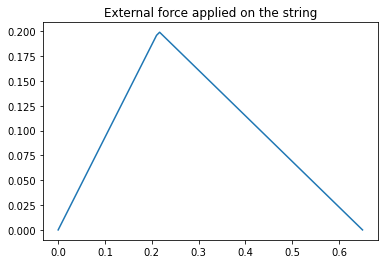

In [8]:
string_data_path = pathlib.Path('./data/guitar_string_config.json')
body_data_path = pathlib.Path('./data/guitar_body_data.csv')
guitar_excitation_config = pathlib.Path('./data/guitar_excitation_config.json')
simulation_config = pathlib.Path('./data/simulation_config.json')
output_path = pathlib.Path('../out/uk')


string_data = load_data_json(GuitarStringData, string_data_path)
body_data = load_data_csv(GuitarBodyData, body_data_path)
f_ext_string = load_data_json(
    Excitation.make_triangular, guitar_excitation_config, l=string_data.l)
simulation = load_data_json(ModalSimulation, simulation_config)


x = np.linspace(0, string_data.l, 100)
f_x = [f_ext_string(u, 0) for u in x]

if do_log:
    print(f"String data: \n {string_data._param_dict}")
    print(f"Body data: \n {body_data._param_dict}")
    print(f"Simulation config \n {simulation._param_dict}")
    plt.plot(x, f_x)
    plt.title("External force applied on the string")
    plt.show()

### Solve system

In [10]:
s = GuitarString(string_data)
b = GuitarBody(body_data)

# There is no external force applied to the body.
f_ext_body = Excitation.make_null()

# The string and body are initially at rest.
q_n_is = [np.zeros(simulation.n.shape, dtype=float) for i in range(2)]
dq_n_is = [np.zeros(simulation.n.shape, dtype=float) for i in range(2)]

# Run the simulation / solve the system.
t, q_ns, dq_ns, ddq_ns, ext_force_n_ts = simulation.run(
    [s, b], [f_ext_string, f_ext_body],
    q_n_is, dq_n_is)

# compute data frames from the result.
df_q_n = make_modetime_dataframe(q_ns[0], simulation.n, t)
df_dq_n = make_modetime_dataframe(dq_ns[0], simulation.n, t)
df_ddq_n = make_modetime_dataframe(ddq_ns[0], simulation.n, t)
df_ext_force_n_t = make_modetime_dataframe(ext_force_n_ts[0], simulation.n, t)

### Save and plot output

ValueError: When stacked is True, each column must be either all positive or all negative. Column '0.02' contains both positive and negative values

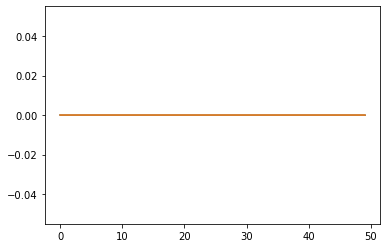

In [11]:
if do_save:
    output_path.mkdir(parents=True, exist_ok=True)
    df_q_n.to_csv(output_path / 'q_n.csv')
    df_ddq_n.to_csv(output_path / 'dq_n.csv')
    df_ddq_n.to_csv(output_path / 'ddq_n.csv')
    df_ext_force_n_t.to_csv(output_path / 'ext_force_n_t.csv')

if do_log:
    # TODO
    # axes = df_q_n.plot(title='$(q_n(t))$', kind='area')